# Reconstruction Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [ ]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import numpy as np

yp.config.setDefaultBackend('arrayfire')
yp.config.setDefaultDatatype('float32')

## Define Output Path

In [2]:
output_path = os.path.expanduser('~/datasets/motiondeblur/beads_output')
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data

In [21]:
!open /Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_strobe_raster_1_motion_deblur_2019_02_04_16_45_48/

In [22]:
# 4.9um beads, 45ms brightness
# dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-v1/beads_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_20_26/'

# 4.9um beads2, 45ms brightness
dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_coded_raster_100_motion_deblur_2019_02_04_16_45_36'
# dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_constant_raster_1_motion_deblur_2019_02_04_16_45_23/'
# dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_strobe_raster_1_motion_deblur_2019_02_04_16_45_48/'
# dataset_full_path = '/Users/zfphil/Dropbox/02-04-19-MotionDeblur-beads2/beads2_line_45ms_stopandstare_stop_and_stare_2019_02_04_16_44_59/'

# Create dataset object (loads metadata)
dataset = Dataset(dataset_full_path, use_median_filter=False, subtract_mean_dark_current=False, force_type='motion_deblur')

Loading 1 frames...


## Perform Registration and Normalization

In [24]:
force = True

# Perform registration
dataset.motiondeblur.register(force=force)

# Perform normalization
dataset.motiondeblur.normalize(force=force)

# Perform kernel shape 
dataset.metadata.calibration['blur_vector'] = {'scale': {'axis': 1, 'factor': 1}}

Loading 18 frames...


## Solve For Single Segment

In [25]:
dataset.frame_mask = [10,11,12,13,14]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, normalize=False, use_psf=False, estimate_background_poly=True)

# Perform reconstruction
recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={})

# Save result
recon.save(output_path, filename=recon.dataset.metadata.file_header + '_no_median', formats=['npz'], save_raw=False, downsample=4)

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    2.07e+12    |       0.00       |    0.00e+00    |  459.8 MB / 3768.0 MB  |
|   10   |    4.92e+09    |       3.92       |    5.30e+03    |  449.7 MB / 3960.1 MB  |
|   20   |    2.17e+09    |       8.01       |    1.24e+04    |  449.6 MB / 3960.1 MB  |
|   30   |    1.08e+09    |      12.08       |    1.36e+04    |  449.7 MB / 3960.1 MB  |
|   40   |    6.52e+08    |      16.18       |    1.02e+04    |  449.7 MB / 3960.1 MB  |
|   50   |    4.30e+08    |      20.27       |    7.27e+03    |  449.7 MB / 3960.1 MB  |
|   60   |    3.05e+08    |      24.36       |    5.58e+03    |  449.7 MB / 3960.1 MB  |
|   70   |    2.29e+08    |      28.46       |    4.57e+03    |  449.7 MB / 3960.1 MB  |
|   80   |    1.77e+08    |      32.53       |    3.86e+03    |  449.7 MB / 3960.1 MB  |
|   90   |    1.40e+0

<IPython.core.display.Javascript object>


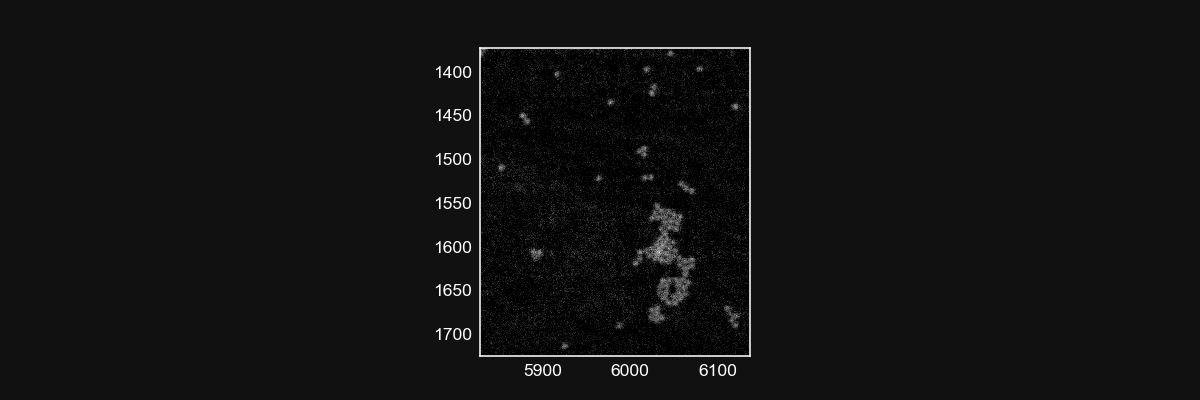

In [30]:
plt.figure()
plt.imshow(recon.object_recovered)
plt.clim(400, 4000)

In [ ]:
recon.show()
plt.clim(0,300)

## Calculate DNF

In [ ]:
x = dataset.motiondeblur.blur_vectors()[0][0][0]

# Normalize
x = x / yp.scalar(yp.sum(x))

# Take fourier transform intensity
x_fft = yp.Ft(x)
sigma_x = yp.abs(x_fft) ** 2

# Calculate DNF
np.sqrt(1 / len(x) * np.sum(1 / sigma_x))

## Loop Over Segments

In [ ]:
for segment_index in dataset.motiondeblur.position_segment_indicies_full:
    # Set segment index
    dataset.motiondeblur.position_segment_indicies = [segment_index]
    
    # Create recon object
    recon = md.recon.Reconstruction(dataset, alpha_blend_distance=1000, pad_mode='mean', )

    # Perform reconstruction
#     recon.reconstruct(iteration_count=-1, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})
    recon.reconstruct(iteration_count=100, step_size=1, frame_number=4, mode='global', reg_types={'l2': 1e-4})

    # Save result
    recon.save(output_path, filename=recon.dataset.metadata.file_header, formats=['png', 'npz'], save_raw=True, downsample=4)

In [ ]:
# Try with L1 Sparsity